## <center> Machine Learning from Scratch at ETH Zurich
## <center> 4. Support Vector Machines with Kernel Tricks
### <center> Zhaorui Gong &nbsp; 宫兆瑞

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import svm
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### 4.1 线性SVM的调包实现与可视化


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



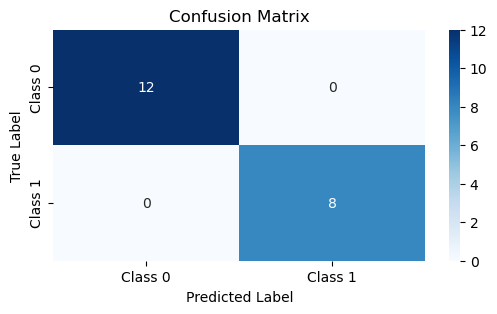

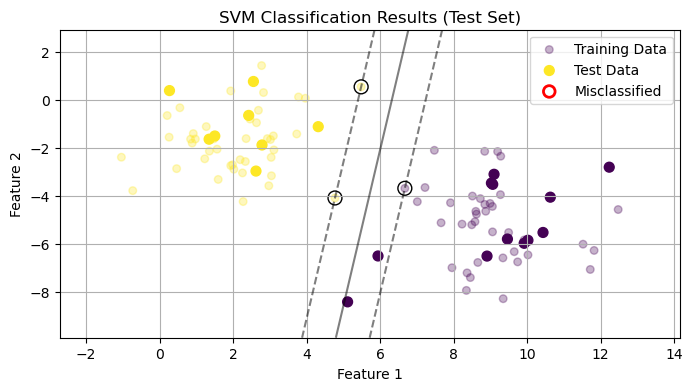

In [5]:
# 1. 生成线性可分数据
X, y = make_blobs(n_samples=100, centers=2, 
                  random_state=200, cluster_std=1.5)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=200)
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train, y_train)


# 2. 预测：testing data与confusion matrix可视化
prediction = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, prediction))

cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. 可视化测试集结果
plt.figure(figsize=(8, 4))
# 绘制训练数据(浅色)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, 
           cmap='viridis', alpha=0.3, label='Training Data')
# 绘制测试数据(深色)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, 
           cmap='viridis', label='Test Data')
# 标记错误分类的点
wrong_pred = y_test != prediction
plt.scatter(X_test[wrong_pred, 0], X_test[wrong_pred, 1], 
           s=70, facecolors='none', edgecolors='red', 
           linewidths=2, label='Misclassified')

# 添加hyperplane与decision boundrary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0]-1, xlim[1]+1, 50)
yy = np.linspace(ylim[0]-1, ylim[1]+1, 50)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

plt.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
plt.contour(XX, YY, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--', '--'])
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], 
           s=100, facecolors='none', edgecolors='k')

plt.title("SVM Classification Results (Test Set)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


### 4.2 SVM from Scratch: linear

理解：
SVM的目标是找到一个最优超平面(决策边界)，使得两类数据点之间的间隔(margin)最大化。这个超平面可以表示为：w · x + b = 0， 其中w是法向量，决定平面的方向；b是intercept，决定位置。

这里我用soft margin约束最小化 ||w||, 也就是最大化 1/||w||。去掉正则化就是hard margin.

作为练习，我写了两种fit，分别为普通梯度下降和随机梯度下降。

In [275]:
import numpy as np
import pandas as pd

class LinearSVM:
    def __init__(self, lambda_param=0.01, learning_rate=0.01, n_iters=5000, tol = 1e-5, batch_size = 50):  # 注意不要乱改参数，模型很脆弱的
        self.lambda_param = lambda_param   # soft margin
        self.lr = learning_rate
        self.n_iters = n_iters
        self.tol = tol
        self.w = None
        self.b = None
        self.batch_size = batch_size
        self.losses = []
    
    def fit(self, X, y):
        n, d = X.shape
        self.w = np.random.randn(d) * 0.01  # 初始化为随即小数
        self.b = 0
        y_ = np.where(np.array(y) <= 0, -1, 1)   # 原本y的取值是0和1，为了适配分类任务，where y <= 0, 它的值要变为-1
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):   # 注意这里的x_i是行向量，维度是d=2.
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b)   # 真实值 * 预测值，看正负

                if condition >= 1:    # boundary条件满足，注意这个"1"是函数margin的标准化约定，保证所有点至少以间隔1被正确分类
                    dw = self.w       # hinge_loss = max(0, 1 - y_i(w'x_i + b)), 此时为0，于是损失函数为 L(w, b) = 1/2 * ||w||^2, 求导就是w
                    db = 0
                else:
                    dw = self.w - self.lambda_param * y_[idx] * x_i   # lambda是正则化系数。损失函数为 L_i(w, b) = 1/2 * ||w||^2 + lambda (1 - y_i(w'x_i + b))，求偏导即可
                    db = -self.lambda_param * y_[idx]
                
                self.w -= self.lr * dw   # 梯度下降
                self.b -= self.lr * db

    def fit_SGD(self, X, y):
        n, d = X.shape
        self.w = np.random.randn(d) * 0.01  # 初始化为随即小数
        self.b = 0
        prev_loss = float("inf")
        count = 0
        y_ = np.where(np.array(y) <= 0, -1, 1)

        for epoch in range(self.n_iters):
            # np.random.seed(200)
            idx = np.random.choice(n, self.batch_size, replace=False)
            if isinstance(X, pd.DataFrame):  # robust, X could be np.array or pd.DataFramne
                X_batch = X.iloc[idx, :]
                y_batch = y_[idx]   # y_ must be np.array
            else:
                X_batch = X[idx]
                y_batch = y_[idx]
            for i, x_i in enumerate(X_batch):
                condition = y_batch[i] * (np.dot(x_i, self.w) + self.b)
 
                if condition >= 1:
                    dw = self.w * self.lambda_param   # 正则项加在l2前 # 损失函数为 L_i(w, b) = lambda /2 * ||w||^2 + (1 - y_i(w'x_i + b))   我不太理解这两种损失函数的区别
                    db = 0
                else:
                    dw = self.lambda_param * self.w - y_batch[i] * x_i
                    db = - y_batch[i]
                
                self.w -= self.lr * dw
                self.b -= self.lr * db

            if epoch % 10 == 0:
                curr_loss = self.hinge_loss(X_batch, y_batch)
                self.losses.append(curr_loss)
                if abs(curr_loss - prev_loss) < self.tol:
                    break
                else:
                    prev_loss = curr_loss
                    count += 10
        print("the total number of epochs is:", count)            
    
    def hinge_loss(self, X, y):
        margin = y * (np.dot(X, self.w) + self.b)
        hinge = np.mean(np.maximum(0, 1-margin))   # 用mean不用sum是为了减小batch_size对结果的影响。注意区分np.max和np.maximum的区别
        l2 = self.lambda_param * np.dot(self.w, self.w) / 2   # lambda 应仅作用于正则化项，这是deepseek给的建议，与lecture不符|
        return l2 + hinge

    
    def predict(self, X_test):
        linear_output = np.dot(X_test, self.w) + self.b
        outcome = np.sign(linear_output)    # 注意这里是1和-1，但作图与习惯上我们要0和1
        return np.where(outcome == -1, 0, 1)
    
    def decision_function(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.dot(X, self.w) + self.b
    
    ##########################以下内容为可视化，非常全面，由Claude生成########################################
    
    def plot_decision_boundary(self, X, y, title="SVM Decision Boundary"):
        """Plot the decision boundary and support vectors"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        plt.figure(figsize=(12, 10))
        
        # Create a mesh for background coloring
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
        
        # Compute decision function on the mesh
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.decision_function(mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot background regions
        plt.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdYlBu')
        
        # Plot hyperplane and margin boundaries
        contour_lines = plt.contour(xx, yy, Z, levels=[-1, 0, 1], 
                                  colors=['red', 'black', 'red'], 
                                  linestyles=['--', '-', '--'], 
                                  linewidths=[2, 3, 2])
        
        # Add labels to contour lines
        plt.clabel(contour_lines, inline=True, fontsize=10, 
                  fmt={-1: 'Margin -1', 0: 'Hyperplane', 1: 'Margin +1'})
        
        # Convert labels to {-1, 1} for support vector calculation
        y_converted = np.where(y == 0, -1, 1)
        
        # Find support vectors
        support_vectors = self.find_support_vectors(X, y_converted)
        
        # Plot regular data points
        colors = ['red', 'blue']
        markers = ['o', 's']
        
        for i, (color, marker) in enumerate(zip(colors, markers)):
            # Plot non-support vectors
            class_mask = (y == i)
            non_support_mask = class_mask & (~support_vectors)
            
            if np.any(non_support_mask):
                plt.scatter(X[non_support_mask, 0], X[non_support_mask, 1], 
                           c=color, marker=marker, s=60, alpha=0.7, 
                           label=f'Class {i}', edgecolors='black', linewidth=1)
        
        # Plot support vectors with special highlighting
        if np.any(support_vectors):
            support_X = X[support_vectors]
            support_y = y[support_vectors]
            
            for i, (color, marker) in enumerate(zip(colors, markers)):
                support_class_mask = (support_y == i)
                if np.any(support_class_mask):
                    plt.scatter(support_X[support_class_mask, 0], 
                               support_X[support_class_mask, 1],
                               c=color, marker=marker, s=120, alpha=1.0,
                               edgecolors='yellow', linewidth=3,
                               label=f'Support Vectors Class {i}')
        
        # Add hyperplane equation as text
        w1, w2 = self.w[0], self.w[1]
        b = self.b
        equation = f'Hyperplane: {w1:.3f}x₁ + {w2:.3f}x₂ + {b:.3f} = 0'
        plt.text(0.02, 0.98, equation, transform=plt.gca().transAxes, 
                fontsize=12, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add margin width
        margin_width = 2 / np.linalg.norm(self.w)
        margin_text = f'Margin width: {margin_width:.3f}'
        plt.text(0.02, 0.94, margin_text, transform=plt.gca().transAxes, 
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.xlabel('Feature 1', fontsize=12)
        plt.ylabel('Feature 2', fontsize=12)
        plt.title(title, fontsize=14)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def find_support_vectors(self, X, y, tolerance=1e-6):
        """Find support vectors (points on or within the margin)"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Compute margins for all points
        margins = y * (np.dot(X, self.w) + self.b)
        
        # Support vectors are points with margin <= 1 + tolerance
        # (on the margin boundary or misclassified)
        support_vectors = margins <= (1 + tolerance)
        
        return support_vectors
    
    def plot_hyperplane_detailed(self, X, y, title="SVM Hyperplane Analysis"):
        """Detailed visualization showing hyperplane geometry"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        # Left plot: Standard decision boundary
        self._plot_on_axis(ax1, X, y, "Decision Boundary with Support Vectors")
        
        # Right plot: Hyperplane normal vector and geometry
        self._plot_hyperplane_geometry(ax2, X, y, "Hyperplane Geometry")
        
        plt.tight_layout()
        plt.show()
    
    def _plot_on_axis(self, ax, X, y, title):
        """Helper function to plot on a specific axis"""
        # Create mesh
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
        
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.decision_function(mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot background and contours
        ax.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdYlBu')
        contour_lines = ax.contour(xx, yy, Z, levels=[-1, 0, 1], 
                                 colors=['red', 'black', 'red'], 
                                 linestyles=['--', '-', '--'], 
                                 linewidths=[2, 3, 2])
        
        # Plot points and support vectors
        y_converted = np.where(y == 0, -1, 1)
        support_vectors = self.find_support_vectors(X, y_converted)
        
        colors = ['red', 'blue']
        for i, color in enumerate(colors):
            class_mask = (y == i)
            non_support_mask = class_mask & (~support_vectors)
            
            if np.any(non_support_mask):
                ax.scatter(X[non_support_mask, 0], X[non_support_mask, 1], 
                          c=color, s=60, alpha=0.7, label=f'Class {i}')
        
        if np.any(support_vectors):
            support_X = X[support_vectors]
            support_y = y[support_vectors]
            
            for i, color in enumerate(colors):
                support_class_mask = (support_y == i)
                if np.any(support_class_mask):
                    ax.scatter(support_X[support_class_mask, 0], 
                              support_X[support_class_mask, 1],
                              c=color, s=120, alpha=1.0, edgecolors='yellow', 
                              linewidth=3, label=f'Support Vectors Class {i}')
        
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_hyperplane_geometry(self, ax, X, y, title):
        """Plot hyperplane with normal vector and geometric interpretation"""
        # Plot data points
        colors = ['red', 'blue']
        for i, color in enumerate(colors):
            idx = np.where(y == i)
            ax.scatter(X[idx, 0], X[idx, 1], c=color, s=60, alpha=0.7, 
                      label=f'Class {i}')
        
        # Plot hyperplane line
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        
        # For 2D: w1*x1 + w2*x2 + b = 0 => x2 = -(w1*x1 + b)/w2
        if abs(self.w[1]) > 1e-6:  # Avoid division by zero
            x1_line = np.linspace(x_min, x_max, 100)
            x2_line = -(self.w[0] * x1_line + self.b) / self.w[1]
            ax.plot(x1_line, x2_line, 'k-', linewidth=3, label='Hyperplane')
            
            # Plot margin lines
            x2_margin_pos = -(self.w[0] * x1_line + self.b - 1) / self.w[1]
            x2_margin_neg = -(self.w[0] * x1_line + self.b + 1) / self.w[1]
            ax.plot(x1_line, x2_margin_pos, 'r--', linewidth=2, label='Margin +1')
            ax.plot(x1_line, x2_margin_neg, 'r--', linewidth=2, label='Margin -1')
        
        # Plot normal vector
        # Start from a point on the hyperplane
        if abs(self.w[1]) > 1e-6:
            x_center = (x_min + x_max) / 2
            y_center = -(self.w[0] * x_center + self.b) / self.w[1]
        else:
            y_center = (X[:, 1].min() + X[:, 1].max()) / 2
            x_center = -self.b / self.w[0]
        
        # Normal vector (scaled for visibility)
        normal_scale = 2
        normal_x = self.w[0] / np.linalg.norm(self.w) * normal_scale
        normal_y = self.w[1] / np.linalg.norm(self.w) * normal_scale
        
        ax.arrow(x_center, y_center, normal_x, normal_y, 
                head_width=0.2, head_length=0.2, fc='green', ec='green', 
                linewidth=3, label='Normal Vector')
        
        # Add text annotations
        ax.text(x_center + normal_x/2, y_center + normal_y/2, 
               f'w = [{self.w[0]:.3f}, {self.w[1]:.3f}]', 
               fontsize=10, ha='center', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')

接下来，我们测试并可视化这个简单的SVM类

the total number of epochs is: 630
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        94

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



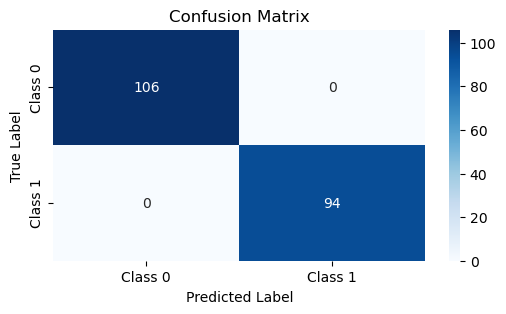

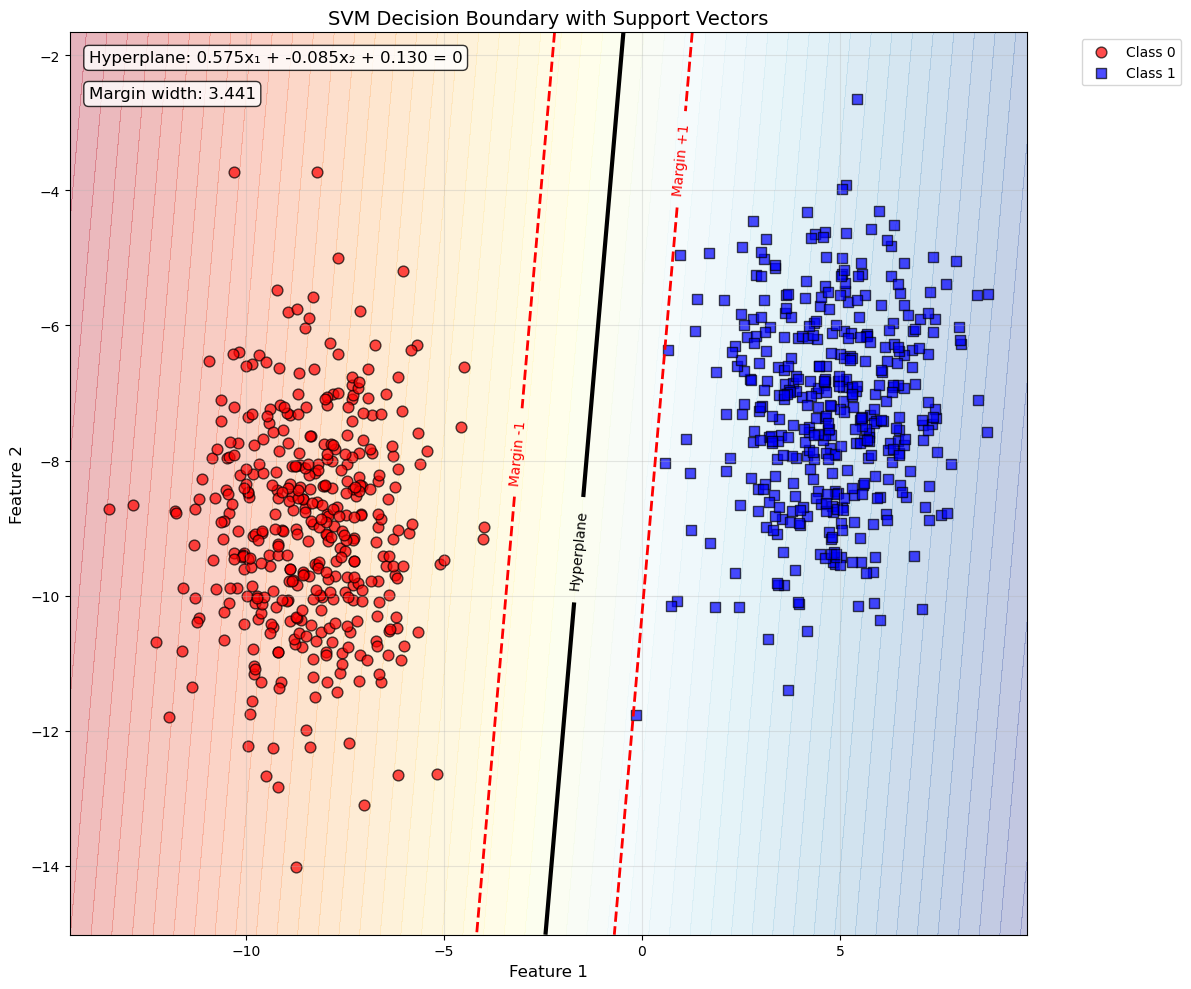

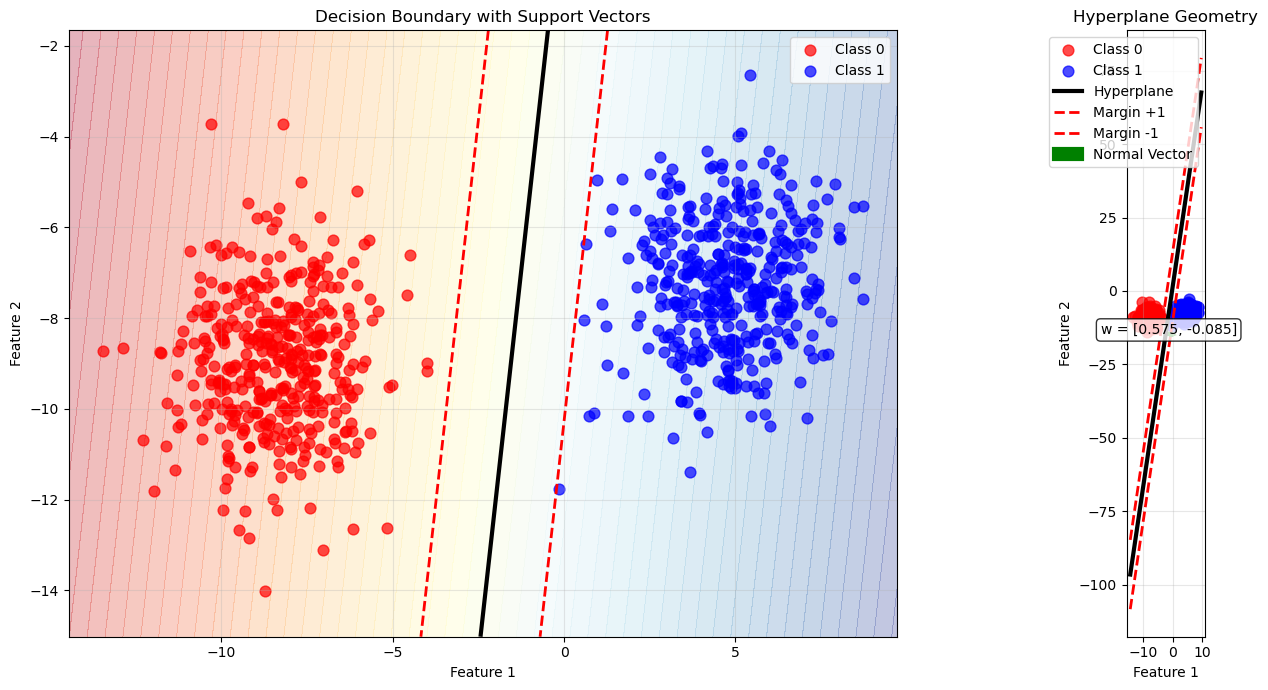

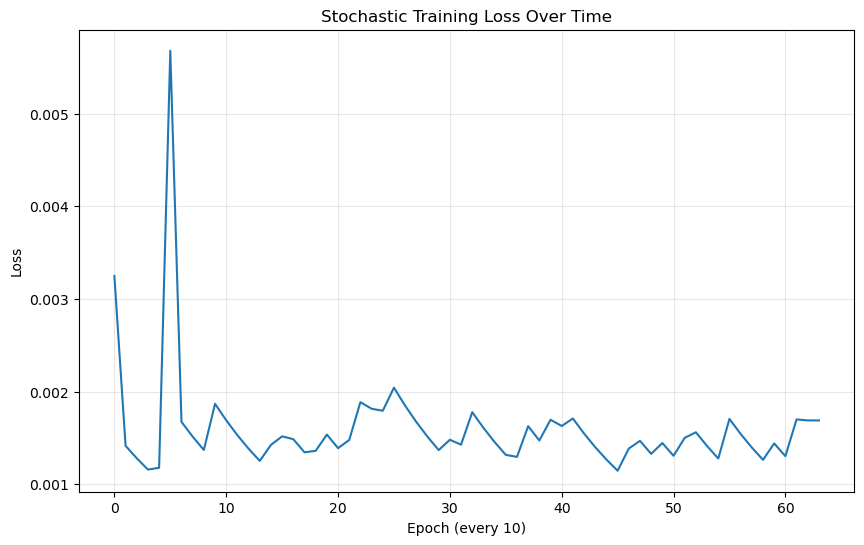


Final weights: [ 0.57495573 -0.0847321 ]
Final bias: 0.12999999999999998
Final loss: 0.0016887680795411742
Number of support vectors: 0
Support vector percentage: 0.0%
Margin width: 3.441359


In [280]:
# 1. 生成线性可分数据。注意这些数据和上面调包用的完全一样
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=1.5)   # 增大std会使数据变得不再线性可分；可加入random_seed以保持数据集不变。
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=200)
clf = LinearSVM()
clf.fit_SGD(X_train, y_train)


# 2. 预测：testing data与confusion matrix可视化
prediction = clf.predict(X_test)
print(classification_report(y_test, prediction))

cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. 平面可视化Plot decision boundary with support vectors
clf.plot_decision_boundary(X_train, y_train, "SVM Decision Boundary with Support Vectors")

# Plot detailed hyperplane analysis
clf.plot_hyperplane_detailed(X_train, y_train)

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(clf.losses)
plt.title('Stochastic Training Loss Over Time')
plt.xlabel('Epoch (every 10)')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Print detailed results
print(f"\nFinal weights: {clf.w}")
print(f"Final bias: {clf.b}")
print(f"Final loss: {clf.losses[-1] if clf.losses else 'N/A'}")

# Print support vector information
y_converted = np.where(y_train == 0, -1, 1)
support_vectors = clf.find_support_vectors(X_train, y_converted)
print(f"Number of support vectors: {np.sum(support_vectors)}")
print(f"Support vector percentage: {100 * np.sum(support_vectors) / len(X_train):.1f}%")

# Print margin width
margin_width = 2 / np.linalg.norm(clf.w)
print(f"Margin width: {margin_width:.6f}")


### 4.3 SVM with Kernels

接下来，我们进入完全非线性可分的世界，比如XOR或者同心圆数据，这需要将features映射到高维，并且用核函数避免过于复杂的运算。接下来我们基于soft margin的hinge loss进行实现。

#### 对偶问题

原始优化问题:
\begin{equation}
\min_{w,b} \frac{\lambda}{2}\|w\|^2 + \frac{1}{n}\sum_{i=1}^n \max(0, 1-y_i f(x_i))
\end{equation}

其中：
$f(x) = w^\top \phi(x) + b$ 是预测函数, 

$\lambda$ 是正则化参数（$\lambda = \frac{1}{C}$）, 

$\phi(\cdot)$ 是特征映射函数

从原始问题的不等式约束优化，用拉格朗日乘子法求解到满足KKT条件，得到对偶问题的拉格朗日函数，对w求导，最优解可表示为：
$$
w = \sum_{i=1}^n \alpha_i y_i \phi(x_i)
$$

将w代入f，因此预测函数变为：
$$
f(x) = \sum_{i=1}^n \alpha_i y_i K(x_i, x) + b
$$

其中核函数定义为：
$$
K(x_i, x_j) = \langle \phi(x_i), \phi(x_j) \rangle
$$

#### 核化SGD的表示：

将$w$表示为支持向量的线性组合：
$$
w = \sum_{j=1}^n \alpha_j y_j \phi(x_j)
$$

更新规则转化为对$\alpha$的操作：
\begin{equation}
\alpha_i \leftarrow 
\begin{cases}
(1 - \eta_t \lambda)\alpha_i + \eta_t * y_i & \text{if} \; \; \; y_i f(x_i) < 1 \\
(1 - \eta_t \lambda)\alpha_i & \text{otherwise}
\end{cases}
\end{equation}

预测函数计算：
$$
f(x) = \sum_{j \in SV} \alpha_j y_j K(x_j, x) + b
$$

RBF Gamma Parameter:

γ = 0.1: Smooth decision boundary (high bias, low variance);

γ = 1.0: Balanced;

γ = 5.0: Complex boundary (low bias, high variance);


Lambda (Regularization):

λ = 0.001: Less regularization (complex model);

λ = 0.01: Balanced;

λ = 0.1: More regularization (simpler model);


Learning Rate:

Start with 0.01-0.1;

Use adaptive decay for stability

### 伪代码
输入: 
  - 训练数据 {(x_i,y_i)}, i=1..n
  - 核函数 K(·,·)
  - 正则化参数 λ
  - 迭代次数 T
  - 初始步长参数 t0

输出: 
  - 模型参数 α, b

过程:
1. 初始化 α = 0, b = 0, t = 0
2. for epoch in 1..T:
3.    随机打乱数据顺序
4.    for i in 1..n:
5.       计算 f_i = ∑_{j=1}^n α_j y_j K(x_j,x_i) + b
6.       设置 η_t = η_{t-1}/((t + λ*t0))
7.       if y_i f_i < 1:
8.           α_i ← (1 - η_t λ)α_i + η_t *y_i
9.           b ← b + η_t y_i
10.      else:
11.          α_i ← (1 - η_t λ)α_i
12.      t ← t + 1
13. 返回 α, b

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles, make_moons
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class SVMKernel:
    def __init__(self, lambda_param=0.01, lr=0.005, tol=1e-5, max_iter=1000, 
                 batchsize=32, gamma=1.0, kernel='rbf'):
        self.lambda_param = lambda_param
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = None
        self.b = None
        self.gamma = gamma
        self.batchsize = batchsize
        self.losses = []
        self.kernel_type = kernel
        self.X_train = None
        self.y_train = None
        self.K = None  # Cached kernel matrix
        
    def rbf_kernel(self, x, z):
        """RBF kernel: exp(-γ||x-z||²)"""
        return np.exp(-self.gamma * np.linalg.norm(x - z)**2)
    
    def polynomial_kernel(self, x, z, degree=3, coef0=1):
        """Polynomial kernel: (γ<x,z> + coef0)^degree"""
        return (self.gamma * np.dot(x, z) + coef0)**degree
    
    def linear_kernel(self, x, z):
        """Linear kernel: <x,z>"""
        return np.dot(x, z)
    
    def compute_kernel(self, x, z):   # 定义三种常见核函数
        """Compute kernel based on kernel type"""
        if self.kernel_type == 'rbf':
            return self.rbf_kernel(x, z)
        elif self.kernel_type == 'polynomial':
            return self.polynomial_kernel(x, z)
        elif self.kernel_type == 'linear':
            return self.linear_kernel(x, z)
        else:
            raise ValueError(f"Unknown kernel type: {self.kernel_type}")
    
    def compute_kernel_matrix(self, X):
        """Compute the full kernel matrix K[i,j] = k(x_i, x_j)"""
        n = len(X)
        K = np.zeros((n, n))    #完全展开，计算每个entry，别想不用for一步算出来
        for i in range(n):
            for j in range(n):
                K[i, j] = self.compute_kernel(X[i], X[j])
        return K
    
    def decision_function(self, X_test):
        """Compute decision function for test points"""
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values
        
        # Handle single point vs multiple points
        if X_test.ndim == 1:
            X_test = X_test.reshape(1, -1)
        
        decisions = []
        for x in X_test:
            f = self.b   # 初始值，等于截距
            for j in range(len(self.y_train)):
                if abs(self.alpha[j]) > 1e-10:  # 只考虑支持向量 (α≠0的样本,KKT互补松弛性,这些点在支持边界上,g(x) = 0)
                    f += self.alpha[j] * self.y_train[j] * self.compute_kernel(self.X_train[j], x)
            decisions.append(f)
        
        return np.array(decisions)
    
    def fit_SGD(self, X, y):
        """Fit SVM using SGD on the dual formulation"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        n, d = X.shape
        self.X_train = X.copy()
        self.y_train = np.where(np.array(y) <= 0, -1, 1)
        
        # Initialize parameters
        self.alpha = np.zeros(n)
        self.b = 0
        
        # Compute kernel matrix once
        print("Computing kernel matrix...")
        self.K = self.compute_kernel_matrix(X)
        
        # SGD training
        prev_loss = float("inf")
        patience = 20
        no_improvement = 0
        
        for epoch in range(self.max_iter):
            # Shuffle indices for each epoch
            indices = np.random.permutation(n)
            
            # Process mini-batches
            for start_idx in range(0, n, self.batchsize):
                end_idx = min(start_idx + self.batchsize, n)
                batch_indices = indices[start_idx:end_idx]
                
                # Adaptive learning rate
                eta = self.lr / (1 + self.lambda_param * epoch)
                
                # Update parameters for each sample in batch
                for i in batch_indices:
                    # Compute decision function for current sample
                    f_i = self.b
                    for j in range(n):
                        if abs(self.alpha[j]) > 1e-10:
                            f_i += self.alpha[j] * self.y_train[j] * self.K[j, i]
                    
                    # Compute margin
                    margin = self.y_train[i] * f_i
                    
                    # Update alpha and bias
                    if margin < 1:
                        # Hinge loss is active
                        self.alpha[i] = (1 - eta * self.lambda_param) * self.alpha[i] + eta * self.y_train[i]
                        self.b = self.b + eta * self.y_train[i]
                    else:
                        # Only regularization
                        self.alpha[i] = (1 - eta * self.lambda_param) * self.alpha[i]
                
                # Clip alpha values to reasonable range
                self.alpha = np.clip(self.alpha, -100, 100)
            
            # Check convergence every 10 epochs
            if epoch % 10 == 0:
                curr_loss = self.compute_loss()
                self.losses.append(curr_loss)
                
                if epoch % 50 == 0:
                    print(f"Epoch {epoch}, Loss: {curr_loss:.6f}, Active alphas: {np.sum(np.abs(self.alpha) > 1e-6)}")
                
                if abs(curr_loss - prev_loss) < self.tol:
                    no_improvement += 1
                    if no_improvement >= patience:   # 需要连续20次Loss的变化小于tol，避免因随机梯度导致算法提前停止
                        print(f"Converged at epoch {epoch}")
                        break
                else:
                    no_improvement = 0
                
                prev_loss = curr_loss
        
        print(f"Training completed. Final loss: {self.losses[-1] if self.losses else 'N/A'}")
        print(f"Number of support vectors: {np.sum(np.abs(self.alpha) > 1e-6)}")
    
    def compute_loss(self):
        """Compute the total loss (hinge loss + regularization)"""
        n = len(self.X_train)
        
        # Regularization term: (1/2) * lambda * alpha^T * K * alpha
        # where K[i,j] = y_i * y_j * k(x_i, x_j)
        reg_term = 0.0
        for i in range(n):
            for j in range(n):
                if abs(self.alpha[i]) > 1e-10 and abs(self.alpha[j]) > 1e-10:   # 都是循环，一项一项加上的，这是最稳妥的求和方法
                    reg_term += self.alpha[i] * self.alpha[j] * self.y_train[i] * self.y_train[j] * self.K[i, j]
        reg_term = 0.5 * self.lambda_param * reg_term
        
        # Hinge loss
        hinge_loss = 0.0
        for i in range(n):
            f_i = self.b
            for j in range(n):
                if abs(self.alpha[j]) > 1e-10:  # 同样，取alpha不为0
                    f_i += self.alpha[j] * self.y_train[j] * self.K[j, i]
            
            hinge_loss += max(0, 1 - self.y_train[i] * f_i)
        
        hinge_loss = hinge_loss / n
        
        return reg_term + hinge_loss
    
    def predict(self, X_test):
        """Predict class labels"""
        decisions = self.decision_function(X_test)
        predictions = np.sign(decisions)
        return np.where(predictions == -1, 0, 1)
    
    def get_support_vectors(self):
        """Get support vectors (points with non-zero alpha)"""
        support_indices = np.where(np.abs(self.alpha) > 1e-6)[0]
        return support_indices, self.X_train[support_indices], self.alpha[support_indices]

########################################以下内容为数据可视化######################################################

    def plot_decision_boundary(self, X, y, title="Kernel SVM Decision Boundary"):
        """Plot decision boundary and support vectors"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        plt.figure(figsize=(8, 4))
        
        # Create mesh for decision boundary
        h = 0.02
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
        
        # Compute decision function on mesh
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.decision_function(mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot decision regions
        plt.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdYlBu')
        
        # Plot decision boundary and margins
        contour_lines = plt.contour(xx, yy, Z, levels=[-1, 0, 1], 
                                  colors=['red', 'black', 'red'], 
                                  linestyles=['--', '-', '--'], 
                                  linewidths=[2, 3, 2])
        
        # Plot data points
        colors = ['red', 'blue']
        for i, color in enumerate(colors):
            class_mask = (y == i)
            plt.scatter(X[class_mask, 0], X[class_mask, 1], 
                       c=color, s=60, alpha=0.7, label=f'Class {i}')
        
        # Plot support vectors
        support_indices, support_vectors, support_alphas = self.get_support_vectors()
        if len(support_indices) > 0:
            support_y = y[support_indices]
            
            for i, color in enumerate(colors):
                support_class_mask = (support_y == i)
                if np.any(support_class_mask):
                    plt.scatter(support_vectors[support_class_mask, 0], 
                               support_vectors[support_class_mask, 1],
                               c=color, s=60, alpha=0.7, edgecolors='yellow', 
                               linewidth=2, label=f'Support Vectors Class {i}')
        
        plt.xlabel('Feature 1', fontsize=12)
        plt.ylabel('Feature 2', fontsize=12)
        plt.title(f'{title} (γ={self.gamma})', fontsize=14)
        plt.legend(bbox_to_anchor=(0.8, 0.6), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_loss_curve(self):
        """Plot training loss curve"""
        if self.losses:
            plt.figure(figsize=(6, 4))
            plt.plot(self.losses, 'b-', linewidth=2)
            plt.title('Training Loss Over Time')
            plt.xlabel('Epoch (every 10)')
            plt.ylabel('Loss')
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print("No loss data available")

##############################################################################################

def compare_kernels():
    """Compare different kernel types on non-linear data"""
    # Generate non-linear data
    X, y = make_circles(n_samples=200, noise=0.1, factor=0.3, random_state=42)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.3, random_state=42)
    
    # Test different kernels
    kernels = [
        ('RBF γ=1', 'rbf', 1.0),
        ('RBF γ=5', 'rbf', 5.0),
        ('RBF γ=0.1', 'rbf', 0.1),
        ('Polynomial', 'polynomial', 1.0)
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    axes = axes.ravel()
    
    for idx, (name, kernel_type, gamma) in enumerate(kernels):
        print(f"\nTesting {name}...")
        
        svm = SVMKernel(lambda_param=0.01, lr=0.01, max_iter=300, 
                       batchsize=16, gamma=gamma, kernel=kernel_type)
        svm.fit_SGD(X_train, y_train)
        
        # Predict and evaluate
        predictions = svm.predict(X_test)
        accuracy = np.mean(predictions == y_test)
        
        # Plot decision boundary
        ax = axes[idx]
        h = 0.02
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
        
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = svm.decision_function(mesh_points)
        Z = Z.reshape(xx.shape)
        
        ax.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdYlBu')
        ax.contour(xx, yy, Z, levels=[0], colors=['black'], linewidths=[2])
        
        colors = ['red', 'blue']
        for i, color in enumerate(colors):
            class_mask = (y == i)
            ax.scatter(X[class_mask, 0], X[class_mask, 1], 
                      c=color, s=40, alpha=0.7, label=f'Class {i}')
        
        # Plot support vectors
        support_indices, support_vectors, _ = svm.get_support_vectors()
        if len(support_indices) > 0:
            ax.scatter(support_vectors[:, 0], support_vectors[:, 1],
                      c='yellow', s=100, alpha=0.8, edgecolors='black', 
                      linewidth=2, marker='s', label='Support Vectors')
        
        ax.set_title(f'{name} (Acc: {accuracy:.3f})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Support vectors: {len(support_indices)}")
    
    plt.tight_layout()
    plt.show()   


接下来生成一个circle数据集，二维线性不可分。我们用rbf核函数试一下。

一些观察：

1. The "double embryos" shape happens because high gamma （0.1就算高了）makes each support vector create a very localized influence, leading to overfitting and non-convex boundaries.

2. The polynomial kernel couldn't distinguish between the two classes.

3. The losses keep increasing, especially with high gammas, and that indicate overfitting, i.e. the model is trying to memorize training points rather than to learn the underlying pattern.

Computing kernel matrix...
Epoch 0, Loss: 0.484759, Active alphas: 660
Epoch 50, Loss: 1.890609, Active alphas: 682
Epoch 100, Loss: 5.237802, Active alphas: 682
Epoch 150, Loss: 9.739952, Active alphas: 682
Training completed. Final loss: 14.064480210427822
Number of support vectors: 682
Test Accuracy: 0.845
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       124
           1       0.74      0.92      0.82        76

    accuracy                           0.84       200
   macro avg       0.84      0.86      0.84       200
weighted avg       0.86      0.84      0.85       200



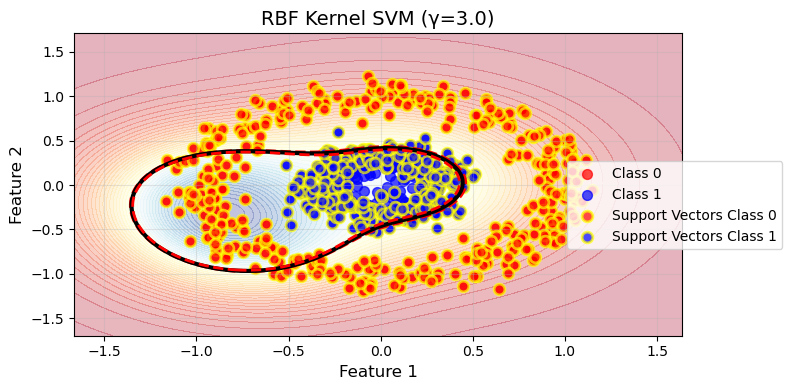

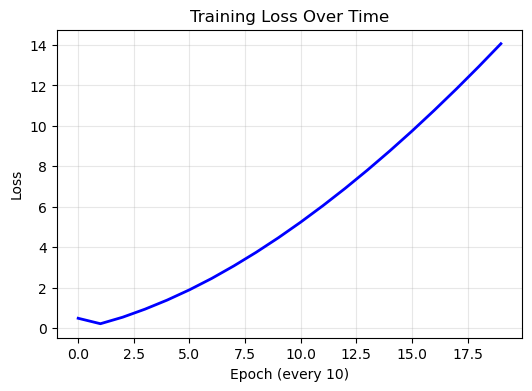

Computing kernel matrix...
Epoch 0, Loss: 0.958529, Active alphas: 438
Epoch 50, Loss: 41.932261, Active alphas: 455
Epoch 100, Loss: 88.950297, Active alphas: 455
Epoch 150, Loss: 143.868339, Active alphas: 456
Training completed. Final loss: 188.47946612046053
Number of support vectors: 456
Test Accuracy: 0.780
              precision    recall  f1-score   support

           0       1.00      0.65      0.78       124
           1       0.63      1.00      0.78        76

    accuracy                           0.78       200
   macro avg       0.82      0.82      0.78       200
weighted avg       0.86      0.78      0.78       200



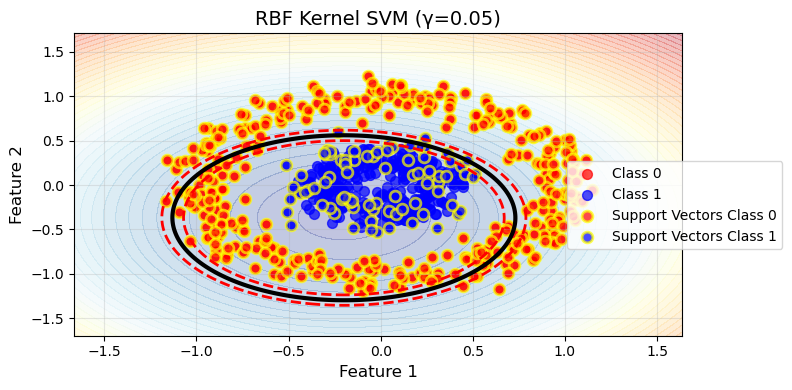

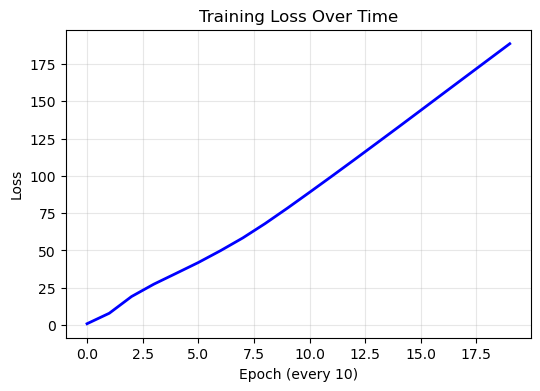


 Comparing different kernels...

Testing RBF γ=1...
Computing kernel matrix...
Epoch 0, Loss: 0.807231, Active alphas: 140
Epoch 50, Loss: 1.210446, Active alphas: 140
Epoch 100, Loss: 2.543467, Active alphas: 140
Epoch 150, Loss: 3.866103, Active alphas: 140
Epoch 200, Loss: 5.135103, Active alphas: 140
Epoch 250, Loss: 6.338185, Active alphas: 140
Training completed. Final loss: 7.269100072859999
Number of support vectors: 140
Accuracy: 0.933
Support vectors: 140

Testing RBF γ=5...
Computing kernel matrix...
Epoch 0, Loss: 0.879756, Active alphas: 140
Epoch 50, Loss: 0.757919, Active alphas: 140
Epoch 100, Loss: 1.410443, Active alphas: 140
Epoch 150, Loss: 2.045054, Active alphas: 140
Epoch 200, Loss: 2.647917, Active alphas: 140
Epoch 250, Loss: 3.216117, Active alphas: 140
Training completed. Final loss: 3.647681800139761
Number of support vectors: 140
Accuracy: 0.950
Support vectors: 140

Testing RBF γ=0.1...
Computing kernel matrix...
Epoch 0, Loss: 0.949812, Active alphas: 12

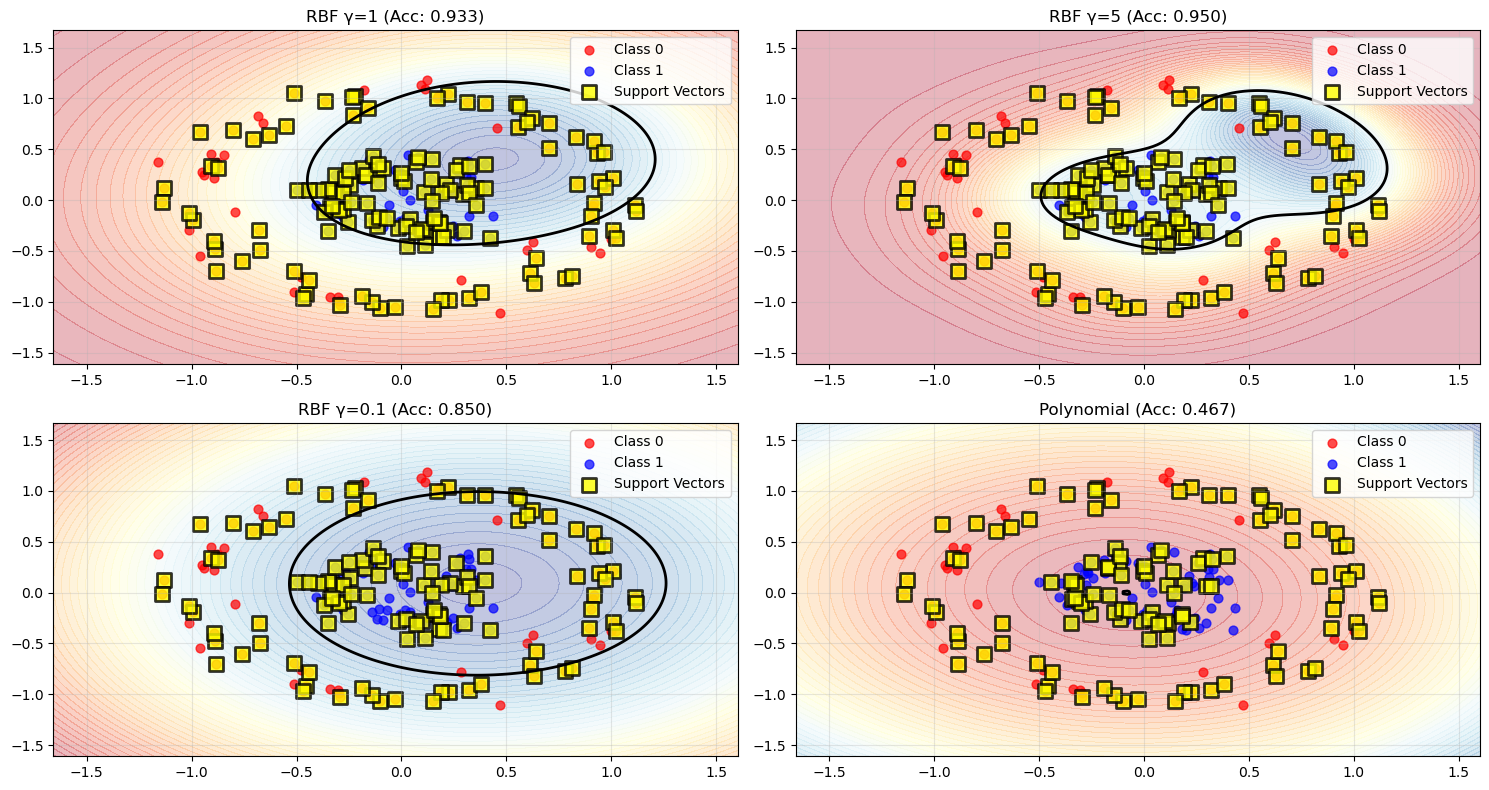

In [345]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# 生成数据
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.3, random_state=78705)   # SGD 适用于大数据集，但为了作图以及运行时间，我们选择1000个点，得跑个十分钟
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=200)
clf1 = SVMKernel(lambda_param=0.001, lr=0.01, max_iter=200, 
                   batchsize=20, gamma=3.0, kernel='rbf')
clf1.fit_SGD(X_train, y_train)
    
predictions = clf1.predict(X_test)
accuracy = np.mean(predictions == y_test)
    
print(f"Test Accuracy: {accuracy:.3f}")
print(classification_report(y_test, predictions))
    
    # Plot results
clf1.plot_decision_boundary(X_train, y_train, "RBF Kernel SVM")
clf1.plot_loss_curve()

clf2 = SVMKernel(lambda_param=0.01, lr=0.01, max_iter=200, 
                   batchsize=20, gamma=0.05, kernel='rbf')
clf2.fit_SGD(X_train, y_train)
    
predictions = clf2.predict(X_test)
accuracy = np.mean(predictions == y_test)
    
print(f"Test Accuracy: {accuracy:.3f}")
print(classification_report(y_test, predictions))
    
    # Plot results
clf2.plot_decision_boundary(X_train, y_train, "RBF Kernel SVM")
clf2.plot_loss_curve()
    # Test 2: Compare different kernels
print("\n Comparing different kernels...")
compare_kernels()

### 4.4 Kernelized SVM using sklearn package

The sklearn version will be much faster and likely more accurate since it uses the SMO algorithm instead of SGD!

1. RBF Kernel SVM
---------------
Test Accuracy: 1.000
Support Vectors: 78
Support Vector Indices: [  6  21  31  41  44  52  61  66  94 111]...

2. Different Kernels
----------------
linear    : Accuracy = 0.647, SVs = 350
rbf_0.1   : Accuracy = 1.000, SVs =  78
rbf_1.0   : Accuracy = 1.000, SVs =  29
rbf_5.0   : Accuracy = 1.000, SVs =  87
poly      : Accuracy = 0.620, SVs = 338
sigmoid   : Accuracy = 0.627, SVs = 204

3. Visualizing RBF with γ=0.1
-------------------------


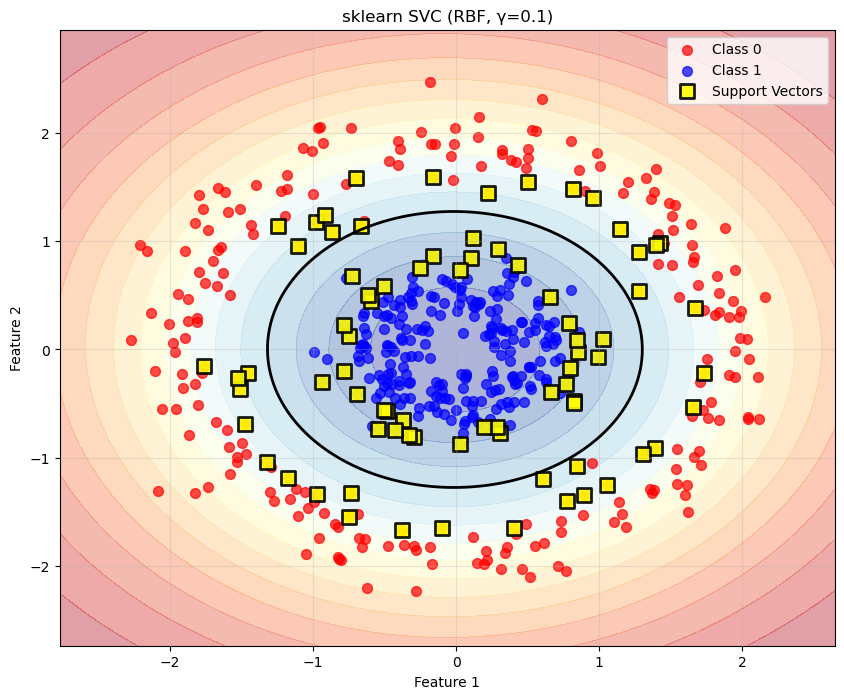


4. Parameter Tuning
----------------
C= 0.1, γ=0.01: Accuracy = 0.887
C= 0.1, γ=0.10: Accuracy = 0.993
C= 0.1, γ=1.00: Accuracy = 1.000
C= 1.0, γ=0.01: Accuracy = 0.887
C= 1.0, γ=0.10: Accuracy = 1.000
C= 1.0, γ=1.00: Accuracy = 1.000
C=10.0, γ=0.01: Accuracy = 0.993
C=10.0, γ=0.10: Accuracy = 1.000
C=10.0, γ=1.00: Accuracy = 1.000

Best parameters: C=0.1, γ=1.0
Best accuracy: 1.000

5. Automatic Parameter Tuning with GridSearchCV
---------------------------------------------
Best parameters: {'C': 0.1, 'gamma': 1}
Best cross-validation score: 1.000
Test accuracy with best params: 1.000

6. Key sklearn SVC Parameters
----------------------------

Common parameters:
- kernel: 'linear', 'rbf', 'poly', 'sigmoid'
- C: Regularization parameter (higher = less regularization)
- gamma: Kernel coefficient for 'rbf', 'poly', 'sigmoid'
  - 'scale': 1 / (n_features * X.var())
  - 'auto': 1 / n_features
  - float: custom value
- degree: Degree for polynomial kernel
- probability: Enable probabilit

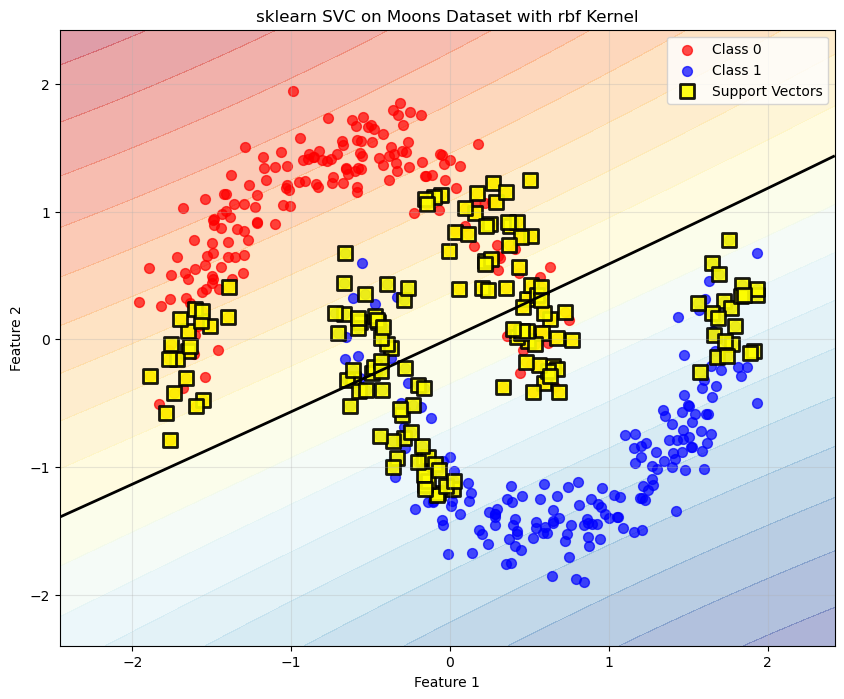

In [348]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Generate same data as your custom SVM
X, y = make_circles(n_samples=500, noise=0.1, factor=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize data (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. RBF Kernel (equivalent to your custom SVM)
print("1. RBF Kernel SVM")
print("-" * 15)

# Create and train SVM
svm_rbf = SVC(kernel='rbf', C=1.0, gamma=0.1)  # C = 1/lambda roughly
svm_rbf.fit(X_train_scaled, y_train)

# Predict and evaluate
predictions = svm_rbf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {accuracy:.3f}")
print(f"Support Vectors: {len(svm_rbf.support_)}")
print(f"Support Vector Indices: {svm_rbf.support_[:10]}...")  # First 10

# 2. Different kernels
print("\n2. Different Kernels")
print("-" * 16)

kernels = {
    'linear': SVC(kernel='linear', C=1.0),
    'rbf_0.1': SVC(kernel='rbf', C=1.0, gamma=0.1),
    'rbf_1.0': SVC(kernel='rbf', C=1.0, gamma=1.0),
    'rbf_5.0': SVC(kernel='rbf', C=1.0, gamma=5.0),
    'poly': SVC(kernel='poly', C=1.0, degree=3),
    'sigmoid': SVC(kernel='sigmoid', C=1.0)
}

for name, svm in kernels.items():
    svm.fit(X_train_scaled, y_train)
    test_acc = accuracy_score(y_test, svm.predict(X_test_scaled))
    print(f"{name:10}: Accuracy = {test_acc:.3f}, SVs = {len(svm.support_):3d}")

# 3. Quick visualization function
def plot_svm_boundary(svm, X, y, title):
    """Plot decision boundary for sklearn SVM"""
    plt.figure(figsize=(10, 8))
    
    # Create mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
    
    # Get decision function values
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, levels=20, alpha=0.4, cmap='RdYlBu')
    plt.contour(xx, yy, Z, levels=[0], colors=['black'], linewidths=[2])
    
    # Plot data points
    colors = ['red', 'blue']
    for i, color in enumerate(colors):
        mask = (y == i)
        plt.scatter(X[mask, 0], X[mask, 1], c=color, s=50, alpha=0.7, label=f'Class {i}')
    
    # Plot support vectors
    plt.scatter(X[svm.support_, 0], X[svm.support_, 1],
               c='yellow', s=100, alpha=0.9, edgecolors='black', 
               linewidth=2, marker='s', label='Support Vectors')
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 4. Visualize best performing kernel
print("\n3. Visualizing RBF with γ=0.1")
print("-" * 25)

# Combine train and test for full visualization
X_full = np.vstack([X_train_scaled, X_test_scaled])
y_full = np.hstack([y_train, y_test])

svm_best = SVC(kernel='rbf', C=1.0, gamma=0.1)
svm_best.fit(X_train_scaled, y_train)
plot_svm_boundary(svm_best, X_full, y_full, "sklearn SVC (RBF, γ=0.1)")

# 5. Parameter tuning example
print("\n4. Parameter Tuning")
print("-" * 16)

# Test different C and gamma combinations
C_values = [0.1, 1.0, 10.0]
gamma_values = [0.01, 0.1, 1.0]

best_score = 0
best_params = {}

for C in C_values:
    for gamma in gamma_values:
        svm = SVC(kernel='rbf', C=C, gamma=gamma)
        svm.fit(X_train_scaled, y_train)
        score = accuracy_score(y_test, svm.predict(X_test_scaled))
        
        print(f"C={C:4.1f}, γ={gamma:4.2f}: Accuracy = {score:.3f}")
        
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'gamma': gamma}

print(f"\nBest parameters: C={best_params['C']}, γ={best_params['gamma']}")
print(f"Best accuracy: {best_score:.3f}")

# 6. Using GridSearchCV for automatic parameter tuning
print("\n5. Automatic Parameter Tuning with GridSearchCV")
print("-" * 45)

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10, 'scale', 'auto']
}

# Create GridSearchCV
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Test on test set
best_svm = grid_search.best_estimator_
test_accuracy = accuracy_score(y_test, best_svm.predict(X_test_scaled))
print(f"Test accuracy with best params: {test_accuracy:.3f}")

# 7. Key sklearn SVC parameters explained
print("\n6. Key sklearn SVC Parameters")
print("-" * 28)
print("""
Common parameters:
- kernel: 'linear', 'rbf', 'poly', 'sigmoid'
- C: Regularization parameter (higher = less regularization)
- gamma: Kernel coefficient for 'rbf', 'poly', 'sigmoid'
  - 'scale': 1 / (n_features * X.var())
  - 'auto': 1 / n_features
  - float: custom value
- degree: Degree for polynomial kernel
- probability: Enable probability estimates (needed for predict_proba)

Relationship to your custom SVM:
- C ≈ 1/lambda_param (inverse relationship)
- gamma: same as your gamma parameter
- sklearn uses SMO algorithm (faster than SGD)
""")

# 8. Comparison with different datasets
print("\n7. Testing on Moons Dataset")
print("-" * 26)

# Generate moons data
X_moons, y_moons = make_moons(n_samples=500, noise=0.1, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_moons, y_moons, test_size=0.3, random_state=42)

# Standardize
X_train_m_scaled = scaler.fit_transform(X_train_m)
X_test_m_scaled = scaler.transform(X_test_m)

# Train SVM
svm_moons = SVC(kernel='rbf', C=1.0, gamma=0.01)
svm_moons.fit(X_train_m_scaled, y_train_m)

accuracy_moons = accuracy_score(y_test_m, svm_moons.predict(X_test_m_scaled))
print(f"Moons dataset accuracy: {accuracy_moons:.3f}")

# Visualize
X_full_m = np.vstack([X_train_m_scaled, X_test_m_scaled])
y_full_m = np.hstack([y_train_m, y_test_m])
plot_svm_boundary(svm_moons, X_full_m, y_full_m, "sklearn SVC on Moons Dataset with rbf Kernel")
